In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from numpy import logical_and as land
from numpy import logical_or as lor
from numpy import invert as lin

In [2]:
def get_theta(mu, cov, rho):
    '''
    Returns explicit threshold theta for a given percentage rho of anomalies in 
    data distributed as a Gaussian with mean mu and covariance matrix cov. 
    
    Parameters
        mu    mean of Gaussian distribution
        cov   covariance matrix of Gaussian distribution
        rho   percentage of anomalies, which must be between 0 and 100 inclusive
    '''
    # generate random variables (data)
    X = multivariate_normal.rvs(mean=mu, cov=cov, size=5000000)
    # center data (normalize) (for x_i - mu)
    Z = X - mu
    # calculate the mahalanobis distance
    # d2M (xi, ˆμ) = (xi − ˆμ)T ˆΣ−1(xi − ˆμ)
    d = np.sqrt(np.sum(Z.dot(inv(cov)) * Z, axis=1))
    # tetha = 
    return np.percentile(d, 100-rho) 

# get_theta([0, 0], [[1, 0], [0, 1]], 5)

In [3]:
# plot settings and utility functions
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']= 16, 10

def save_point_plot(data, outliers_indices, fpath):
    '''
    plot 2dim data and save them to file
   
    data data plotted blue 
    outliers_indices if is not None, indices which are True will be plotted red
    '''
    
    outliers = data[outliers_indices, :]
    data = data[lin(outliers_indices), :]
    
    # Plotting the generated samples
    plt.plot(data[:,0], data[:,1], 'o', c='blue',
             markeredgewidth = 0.5,
             markeredgecolor = 'black')
    
    plt.plot(outliers[:,0], outliers[:,1], 'o', c='red',
             markeredgewidth = 0.5,
             markeredgecolor = 'black')
        
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.axis('equal')
     
    plt.savefig(fpath, bbox_inches='tight')
    

# Assignment
1. Sample a data set D of size n from N (x; μ, Σ). Fix a percentage ρ.
2. Use the function get_theta(mu, cov, rho) provided by the notebook to
obtain an explicit threshold θ given the percentage ρ. Note that θ is part
of the ground-truth and therefore considered as unknown.
3. Determine the true anomalies of D. For this, use the explicit threshold θ
together with the Mahalanobis distance d∗
M defined by the true μ and Σ.
4. Use the data D to estimate μ and Σ. Construct the Mahalanobis distance
dM defined by the estimates ˆμ and ˆΣ.
5. Predict the anomalies of D using the Mahalanobis distance dM and Eu-
clidean distance dE . Anomalies are the ρ percent points xi ∈ D farthest
from ˆμ (do not use θ). Assess precision and recall of both detectors.

In [4]:
# function to evaluate the whole assignment and save the plotted figure
def evaluate(mu_T=np.array([0, 0]), covariance=.9, rho=3.5, size=2000, savefig=True):
    # fixate groundtruth mean and covariance matrix for the bivariate gaussian distribution
    # '_T' nominator stands for groundtruth variable
    # '_E' nominator stands for estimated variable
    sigma_T = np.array([[1, covariance], [covariance, 1]])  # covariance matrix
    
    # 1. generate dataset (RandomVariableS)
    D = multivariate_normal.rvs(mean=mu_T, cov=sigma_T, size=size)
    
    # 2. use get_theta to get the 'groundtruth' explicit treshold theta
    theta = get_theta(mu_T, sigma_T, rho)
    
    # 3. determine subset of true anomalies of dataset D
    # start by calculating the mahalanobis distance of each point from the mean
    Z_T = D - mu_T
    d_m_T = np.sqrt(np.sum(Z_T.dot(inv(sigma_T)) * Z_T, axis=1))
    
    # filter out values (indices) over the groundtruth threshold theta (True / False array)
    I_T = d_m_T > theta  # indices of true anomalies with mahalanobis distance
    
    # 4. Use the data D to estimate mu and sigma
    mu_E = D.mean(axis=0)
    sigma_E = np.cov(D.T) 
    
    # Construct the Mahalanobis distance d_m_E defined by the estimates mu_E and sigma_E
    Z_E = D - mu_E
    d_m_E = np.sqrt(np.sum(Z_E.dot(inv(sigma_E)) * Z_E, axis=1))
    
    # construct euklidian distance d_e_E in the same manner (with mu_E and sigma_E)
    d_e_E = np.sqrt(np.sum(Z_E ** 2, axis=1)) 
    
    # 5. predict anomalies with estimated eucilidian (d_e_E) and mahalanobis distance (d_m_E)
    # create list of indices (True / False array) (on axis 0 of dataset)
    # estimated thresholds (eta) are rho percent points with the farthest distance from mu_E
    eta_m = np.percentile(d_m_E, 100-rho)
    eta_e = np.percentile(d_e_E, 100-rho) 

    I_m_E = d_m_E > eta_m
    I_e_E = d_e_E > eta_e 
    
    # Comparison:
    # Assess precision and recall of both detectors. (5)
    # calculate tp, fp and fn for euklidian distance and for mahalanobis distance

    # np.logical_and(I_m_T, I_m_E) [here: land] creates a logical AND mask over the two boolean arrays etc.
    # (I_m_T * I_m_E)
    tp_m = land(I_T, I_m_E).sum()
    tp_e = land(I_T, I_e_E).sum()

    fp_m = land(lin(I_T), I_m_E).sum()
    fp_e = land(lin(I_T), I_e_E).sum()

    fn_m = land(I_T, lin(I_m_E)).sum()
    fn_e = land(I_T, lin(I_e_E)).sum()

    # precisions and recalls mahalanobis (m) and euklidian (e) distance
    precision_m = tp_m / (tp_m + fp_m) 
    recall_m = tp_m / (tp_m + fn_m)

    precision_e = tp_e / (tp_e + fp_e)
    recall_e = tp_e / (tp_e + fn_e)

    print(f'precision euklidian : {precision_e}')
    print(f'recall euklidian : {recall_e}')
    print(f'precision mahalanobis : {precision_m}')
    print(f'recall mahalanobis : {recall_m}')
    
    if savefig:
        save_point_plot(D, I_T, f'./research_question_imgs/{rho}_groundtruth.png')
        save_point_plot(D, I_m_E, f'./research_question_imgs/{rho}_mahalanobis_estimated.png')
        save_point_plot(D, I_e_E, f'./research_question_imgs/{rho}_euklidian_estimated.png')

## Research question of choice : How do precision and recall depend on percentage __p__?


rho = 1
precision euklidian : 0.35
recall euklidian : 0.5
precision mahalanobis : 0.7
recall mahalanobis : 1.0

rho = 4
precision euklidian : 0.5125
recall euklidian : 0.4939759036144578
precision mahalanobis : 0.975
recall mahalanobis : 0.9397590361445783

rho = 7
precision euklidian : 0.5285714285714286
recall euklidian : 0.5068493150684932
precision mahalanobis : 0.9857142857142858
recall mahalanobis : 0.9452054794520548

rho = 10
precision euklidian : 0.63
recall euklidian : 0.5675675675675675
precision mahalanobis : 1.0
recall mahalanobis : 0.9009009009009009

rho = 13
precision euklidian : 0.5961538461538461
recall euklidian : 0.5805243445692884
precision mahalanobis : 0.9961538461538462
recall mahalanobis : 0.9700374531835206

rho = 16
precision euklidian : 0.55
recall euklidian : 0.5886287625418061
precision mahalanobis : 0.93125
recall mahalanobis : 0.9966555183946488

rho = 19
precision euklidian : 0.5710526315789474
recall euklidian : 0.5977961432506887
precision mahalanobi

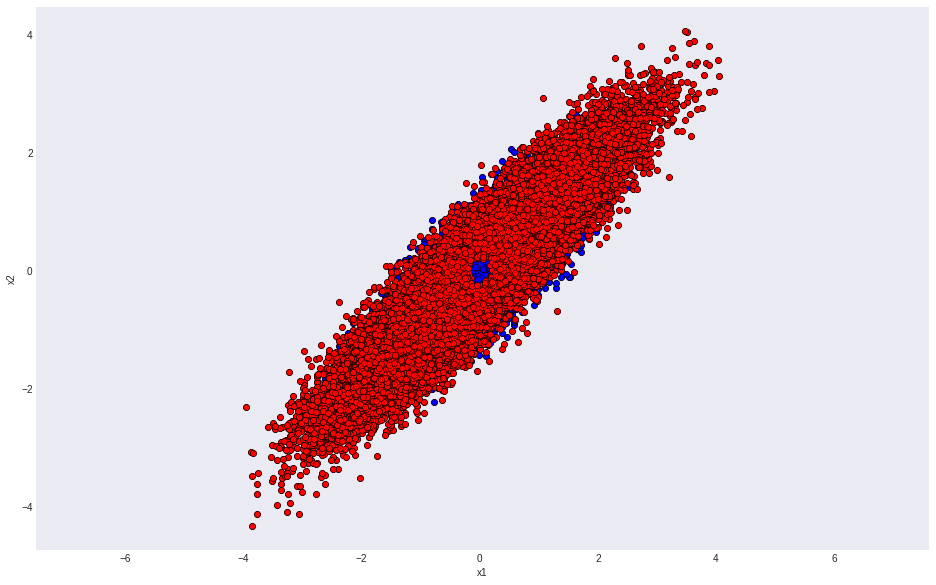

In [5]:
# loop through the whole evaluation process with always 
# augmenting values of rho
# save the anomalies plots for each percentage evaluation
# for groundtruth, estimated euklidian and mahalanobis distance
for i in range(1, 99, 3):
    print(f'\nrho = {i}')
    evaluate(rho=i)

## results:

More outliers (higher rho) makes the euklidian distance work better than with lower rho. The mahalanobis distance works in any equal.

**Why?**

The euklidian distance measures unrelative (circular-shape) to the pdf, and since the nearer you get to the mean (mu) of the pdf the more points occur in a gaussian distribution, the less 'meaning' the co-dependence of the two axis gets. Since the mahalanobis distance works relatively (oval-shaped) to the density function, its performance wont change (oval). This only applies if the two variables are co-dependant (covariance not zero). Else neither distance measurement works better.